# Collaborative Filtering example 

In [83]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
class CF(object):
    #     hàm khởi tạo
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        #  dist_func là hàm đo độ tương tự giữa 2 vecto
        # uuCF =1 thì xét user base, 0 thì xét item base
        self.uuCF = uuCF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
#  chuyển thành ma trận normalize
    def normalize_Y(self):
        users = self.Y_data[:, 0]
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            ids = np.where(users == n)[0].astype(np.int32)
            item_ids = self.Y_data[ids, 1] 
            ratings = self.Y_data[ids, 2]
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 
            self.mu[n] = m
            self.Ybar_data[ids, 2] = ratings - self.mu[n]
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr() 
    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
        return self.S
    #lấy ra 10 user có độ tương đồng lớn nhất với user u
    def top10sim(self,u):
        simu=[]
        for i in range(0,len(self.similarity()[0])):
            simu.append(self.similarity()[u][i])
            
        ma=[] #lưu 10 user có sim cao nhất
        while (len(ma)<10):
            a=0 #biến lưu sim
            m=simu[0] # lưu phần tử có sim cao nhất
            index=0
            for i in range(0, len(simu)):
                if simu[i]>a and i!=u:
                    m=simu[i]
                    a=simu[i]
                    index=i
                    s=str(index)+" "+str(m)
            ma.append(s)
            del simu[index]
        return ma 
        
    def refresh(self):
        self.normalize_Y()
        self.similarity() 
    def fit(self):
        self.refresh()
        
#     du doan rating ma user u cho film i
    def __pred(self, u, i, normalized = 1):
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        sim = self.S[u, users_rated_i]
        a = np.argsort(sim)[-self.k:] 
        nearest_s = sim[a]
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)
        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    def pred(self, u, i, normalized = 1):
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
    
#     lay ra bo phim ma user u co the thich nhat va rating du doan
    def recommend(self, u):
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        for i in range(self.n_items):
            if i not in items_rated_by_u:
                rating = self.pred(u, i)
                if rating > 0:
                    a= i,rating
                    recommended_items.append(a)
        ma=[] #lưu 10 film có rate được dự đoán cao nhất
        while (len(ma)<10):
            a=0 #biến lưu rating
            m=recommended_items[0] # lưu phần tử có rating cao nhất
            index=0
            for i in range(0, len(recommended_items)):
                if recommended_items[i][1]>a:
                    m=recommended_items[i]
                    a=recommended_items[i][1]
                    index=i
            ma.append(m)
            del recommended_items[index]
        return ma 
    
#     def print_recommendation(self,k):
#         recommended_items = self.recommend(k)
#         print ('Recommend film:', recommended_items, 'for user', k)

In [84]:
                                #chia file train (ub.base) thành 2 file 70% và 30% độ lớn
# f_to_split = "ml-100k/ub.base"
 
# ltotal = len(open(f_to_split, 'rb').read())
# lim_70 = int(ltotal * .70)
# if lim_70 < 1: lim_70=1
# lim_30 = int(ltotal * .30)
# if lim_30 < 1: lim_30=1
# lim_70_count = 0
# lim_30_count = 0
 
# fin = open(f_to_split, 'rb')
# f70out = open("70f.base", 'wb')
# f30out = open("30f.base", 'wb')
# for line in fin:
#     r = random.random()
#     if r < 0.70 and lim_70_count < lim_70 or r >= 0.70 and lim_30_count > lim_30:
#         lim_70_count += 1
#         f70out.write(line)
#     else:
#         lim_30_count += 1
#         f30out.write(line)

In [85]:
#đọc 2 file mà mình vừa chia để thao tác
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('70f.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('30f.base', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base.as_matrix()
rate_test = ratings_test.as_matrix()

rate_train[:, :2] -= 1
rate_test[:, :2] -= 1
Y_data = ratings_base.as_matrix()
rs = CF(Y_data, k = 10,uuCF = 1)
rs.fit()

rs.top10sim(5)
# rs.print_recommendation(3)

['33 0.22645540682891918',
 '650 0.20965696734438366',
 '612 0.18531232916527532',
 '195 0.16248558255167678',
 '132 0.16012815380508716',
 '422 0.16012815380508716',
 '852 0.16012815380508716',
 '385 0.15504341823651058',
 '292 0.15408338784034142',
 '453 0.15384615384615385']

6


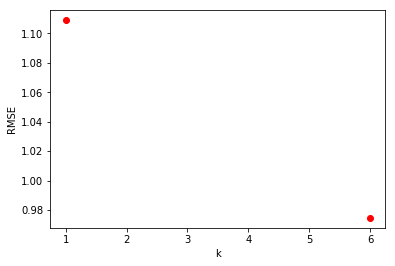

In [86]:
# show giá trị RMSE với các giá trị k
i=1
min=1
index=0
while(i<500):
    rs = CF(rate_train, k = i, uuCF = 1)
    rs.fit()
    n_tests = rate_test.shape[0]
    SE = 0 
    for n in range(n_tests):
        pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
        SE += (pred - rate_test[n, 2])**2
    RMSE = np.sqrt(SE/n_tests)
    if RMSE<min:
        index=i
    plt.ylabel('RMSE')
    plt.xlabel('k')
    plt.plot(i,RMSE,'ro-')
    i +=5
print(index)
plt.show()

In [87]:
#thực hiện kiểm tra với file test
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('ml-100k/ub.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('ml-100k/ub.test', sep='\t', names=r_cols, encoding='latin-1')

rate_train = ratings_base.as_matrix()
rate_test = ratings_test.as_matrix()

rate_train[:, :2] -= 1
rate_test[:, :2] -= 1
Y_data = ratings_base.as_matrix()
rs = CF(Y_data, k = 86,uuCF = 1)
rs.fit()
# rs.top10sim(5)
print ('User - User, RMSE =', RMSE)

User - User, RMSE = 0.9745823176637998


In [88]:
#kết quả với item base
rs = CF(rate_train, k = i, uuCF = 1)
rs.fit()
n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs.pred(rate_test[n, 0], rate_test[n, 1], normalized = 0)
    SE += (pred - rate_test[n, 2])**2
RMSE = np.sqrt(SE/n_tests)
rs = CF(Y_data, k = 86, uuCF = 0)
rs.fit()
print ('item-item CF, RMSE =', RMSE)

c:\users\duc quan\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\duc quan\appdata\local\programs\python\python36-32\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


item-item CF, RMSE = 1.0043300006260247
